# NXPol gridded data files tutorial - Single timestep files

This notebook introduces gridded radar data from NCAS's X-band dual-polarisation radar (NXPol). These netcdf files contain precipitation estimates on a 1km Cartesian grid (OS national grid format) to match the UK precipitation composite grid at this resolution.

The notebook will explore:
1. Opening the file(s) into an xarray dataset
2. Plotting the precipitation estimates spatially
3. Extracting timeseries of precipitation intensity at specified point locations

To achieve that we'll import and use the following python packages:

In [1]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
import os
import cartopy
from pyproj import Transformer
from pyproj import CRS

## 1. Accessing and opening the data files

The data files have been written to be easily readable using the python package [xarray](https://docs.xarray.dev/en/stable/).

The data files are stored on Jasmin - first we'll create a list of files to use in the tutorial. There are many ways to do this in python, here we'll use the os package and a list comprehension to grab all the files within a specified data folder.

In [2]:
data_folder = '/gws/smf/j07/ncas_radar/dufton_raine/raine_v5_1_quality_grid/20181101/GRID/'

In [3]:
data_files = os.listdir(data_folder) # Use os to list all files in the directory
data_files.sort() # Sort the list, making use of the naming structure of the files to create a time ordered list

# Use a list comprehension to go from file names to full paths
data_files = [os.path.join(data_folder,data_file) for data_file in data_files]

Now we can use xarray to read all those files (or a subset thereof) into an xarray dataset object. Here we'll use a subset of the files to reduce read time, but reading an entire day is easily possible, so feel free to experiment.

In [4]:
Nxpol_dataset = xarray.open_mfdataset(data_files[:25])

Now we can explore the dataset object and the data fields within:

In [5]:
Nxpol_dataset

<xarray.Dataset> Size: 30MB
Dimensions:             (Time: 25, y: 310, x: 310)
Coordinates:
  * Time                (Time) datetime64[ns] 200B 2018-11-01T00:04:10 ... 20...
    lat                 (y, x) float32 384kB dask.array<chunksize=(310, 310), meta=np.ndarray>
    lon                 (y, x) float32 384kB dask.array<chunksize=(310, 310), meta=np.ndarray>
  * x                   (x) float32 1kB 1.405e+05 1.415e+05 ... 4.495e+05
  * y                   (y) float32 1kB 3.605e+05 3.615e+05 ... 6.695e+05
Data variables:
    crs                 (Time) int64 200B -9223372036854775806 ... -922337203...
    Rainfall_ZC_DLUE    (Time, y, x) float32 10MB dask.array<chunksize=(1, 310, 310), meta=np.ndarray>
    beam_altitude_DLUE  (Time, y, x) float32 10MB dask.array<chunksize=(1, 310, 310), meta=np.ndarray>
    QIND_DLUE           (Time, y, x) float32 10MB dask.array<chunksize=(1, 310, 310), meta=np.ndarray>
Attributes: (12/22)
    comment:                         Gridded netcdf output created using weig...
    source:                          NCAS Mobile X-band radar
    data_set_version:                0.0
    location_keywords:               Sandwith, Cumrbia, England, UK
    institution:                     National Centre for Atmospheric Science ...
    creator_name:                    David Dufton
    ...                              ...
    data_source:                     NXPOL radar, Selex Gematronik 50DX Mobil...
    platform_name:                   Sandwith
    platform_location:               X
    licence:                         Data usage licence - UK Government. Open...
    creation_date:                   2024-04-09 08:45
    source_file:                     Gridded from /gws/smf/j07/ncas_radar/duf...

We can see that the dataset has three dimensions, "Time" which is equal in length to the number of files read and 'x' and 'y', which are the projection coordinates of the grid centroids. In addition there are two subsidary coordiante arrays, which are the latitude and longitude of each grid centroid (on a 2D grid, due to projection distortion).

The dataset also contains the three fields found in the data files, these are **Rainfall_ZC_DLUE**, **beam_altitude_DLUE** and **QIND_DLUE**.

- **Rainfall_ZC_DLUE**: Precipitation intensity derived from corrected reflectivity - dynamically flattened to the lowest usable elevation before gridding. Grid is a quality and area weighted average of polar data 
- **beam_altitude_DLUE**: Altitude above mean sea level (reference level) of the radar beam (quality weighted mean of the polar data contributing to the grid box).
- **QIND_DLUE**: Quality index - flattened and gridded as per the rainfall field.

Data outside the range of the radar has a value of -1 in the data files. We'll change this to nan for plotting purposes here:

In [6]:
Nxpol_dataset['Rainfall_ZC_DLUE'].values = np.where(Nxpol_dataset['Rainfall_ZC_DLUE'].values==-1,
                                                    np.nan,
                                                    Nxpol_dataset['Rainfall_ZC_DLUE'].values)
Nxpol_dataset['QIND_DLUE'].values = np.where(Nxpol_dataset['QIND_DLUE'].values==-1,
                                                    np.nan,
                                                    Nxpol_dataset['QIND_DLUE'].values)
Nxpol_dataset['beam_altitude_DLUE'].values = np.where(Nxpol_dataset['beam_altitude_DLUE'].values==-1,
                                                    np.nan,
                                                    Nxpol_dataset['beam_altitude_DLUE'].values)

## 2. Plotting simple visualisations

We can now use xarray's inbuilt plot routines. They add axes labels and colorbar labels which wouldn't be added by just using matplotlib, allowing a quicker look at what the data structure actually is. First we'll show a single timestep of the data and then a timeseries for a single location. Xarray also allows fancier indexing and selection using actual dimensions, which we will look at later.

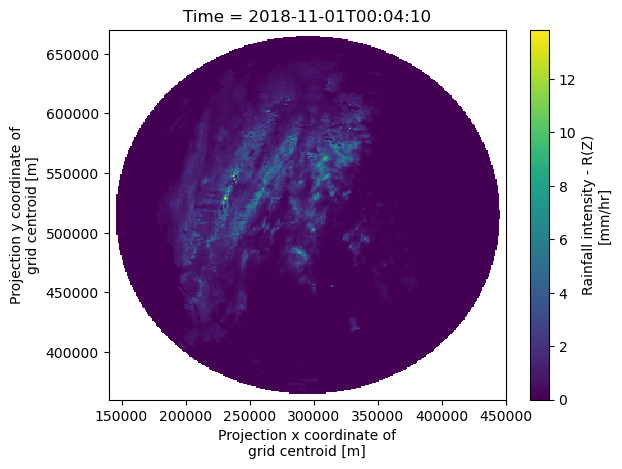

In [7]:
Nxpol_dataset['Rainfall_ZC_DLUE'][0].plot() # 'Time' is the first dimension, so we can use array style indexing to select the first timestep.

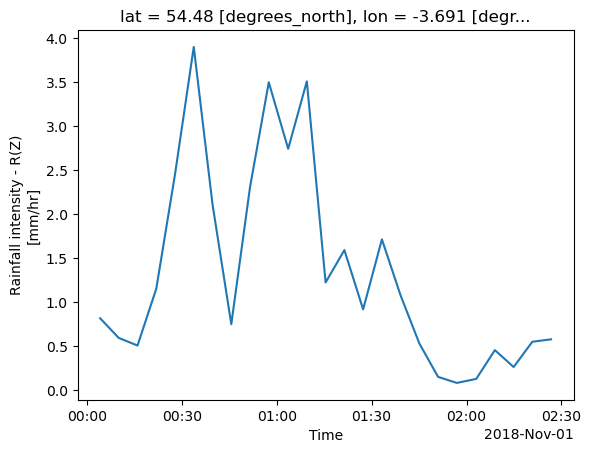

In [8]:
Nxpol_dataset['Rainfall_ZC_DLUE'][:,150,150].plot() # Take all 'Time' (first index) for the grid box at x,y index location 150,150.

While the 2D view provides geographic axes it is often easier to locate data through reference to coastlines (especially in the British Isles). In order to plot coastlines we'll use the Cartopy package and define a projection to match that of the OS British National Grid. We can then add a coastline to the xarray plot.

In [9]:
cart_osgb = cartopy.crs.TransverseMercator(central_longitude=-2.0,
                                           central_latitude=49.0,
                                           false_easting=400000,
                                           false_northing=-100000,
                                           scale_factor=0.9996012717)

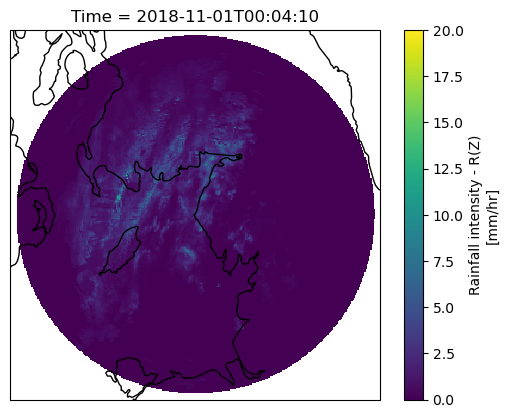

In [10]:
ax = plt.subplot(111, projection=cart_osgb)
Nxpol_dataset['Rainfall_ZC_DLUE'][0].plot.imshow(vmin=0,vmax=20)
ax.coastlines()

To gain more flexibility in plotting we can step back to using matplotlib. In this case we'll use that flexibility to mask out very low / zero values of precipitation intensity, making it clearer where precipitation is falling within the radar domain. We'll then add matplotlib labels and titles to match the xarray plot as closely as possible. By using a loop we can generate multiple plots, in this example one for every fifth timestep.

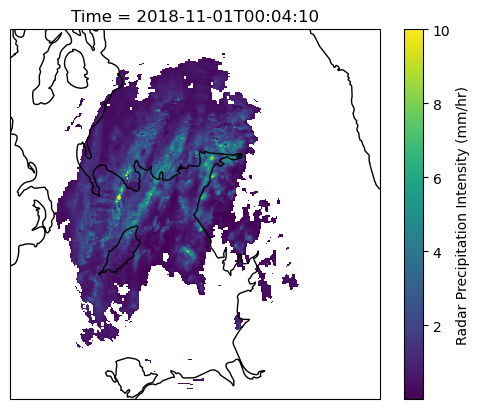

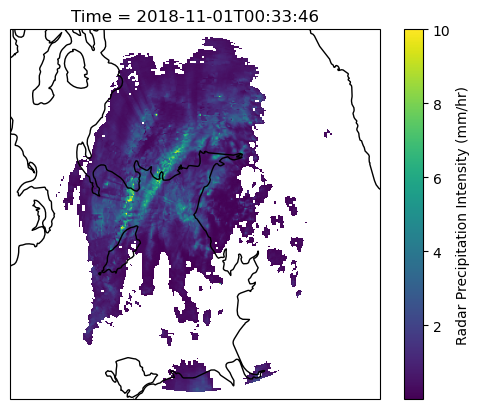

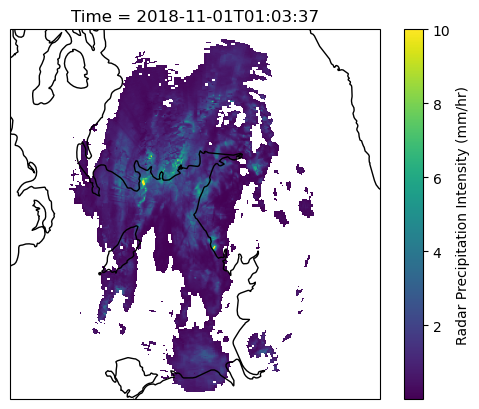

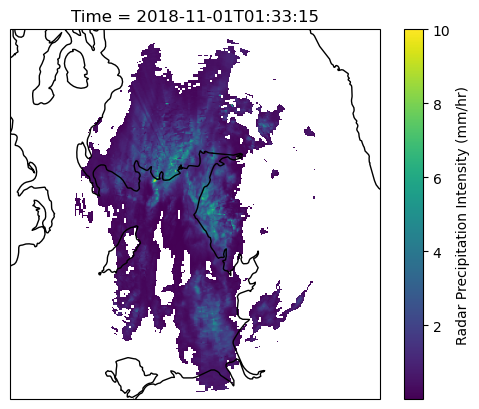

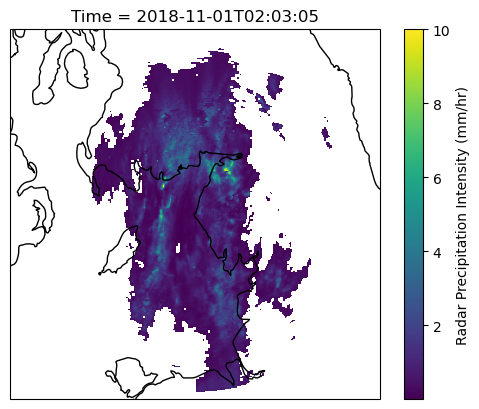

In [11]:
for i in range(0,25,5):
    ax = plt.subplot(111, projection=cart_osgb)
    plt.imshow(np.ma.masked_less(Nxpol_dataset['Rainfall_ZC_DLUE'][i],0.01),
               origin='lower',
               extent=(Nxpol_dataset['x'][0],Nxpol_dataset['x'][-1],
                       Nxpol_dataset['y'][0],Nxpol_dataset['y'][-1]),
               vmin=0.01,vmax=10)
    plt.colorbar(label="Radar Precipitation Intensity (mm/hr)")
    plt.title('Time = {}'.format(Nxpol_dataset['Time'][i].values).split('.')[0])
    ax.coastlines(resolution='10m')
    plt.show()

## 3. Extracting timeseries from specified locations

We can use nearest neighbour lookups [(Docs)](https://docs.xarray.dev/en/latest/user-guide/indexing.html#nearest-neighbor-lookups) to extract the closest grid cell values to a specified location. Here we'll define 3 random points and extract time series of precipitation intensity at each location. If we specify the points using latitude and longitude coordinates we can convert those to the reference system of the radar grid (OSGB) before finding the nearest grid centroid to each point.

First we'll print out the full spatial range of the grid files, you can then adjust the random points from the values selected already within that range to see how things change. You could also add additional points spaced around the domain.

In [12]:
print('The radar domain covers latitudes between {:.3f} and {:.3f}'.format(np.nanmin(Nxpol_dataset['lat'].values),
                                                                   np.nanmax(Nxpol_dataset['lat'].values)))
print('The radar domain covers longitudes between {:.3f} and {:.3f}'.format(np.nanmin(Nxpol_dataset['lon'].values),
                                                                   np.nanmax(Nxpol_dataset['lon'].values)))

The radar domain covers latitudes between 53.078 and 55.919
The radar domain covers longitudes between -6.147 and -1.210


In [13]:
# Define some random points to look at, using tuple pairs of lat-lon in a list:
points_of_interest = [(54.15,-3.11),
                      (54.6,-3.5),
                      (55.2,-3.8)]


# Vectorise the latitudes and longitudes from the list
points_of_interest_latitudes = [poi[0] for poi in points_of_interest]
points_of_interest_longitudes = [poi[1] for poi in points_of_interest]


# Transform the point coordiantes from latitude and longitude to the grid refernce from the data file (OSGB)
transformer = Transformer.from_crs("EPSG:4326", CRS(Nxpol_dataset['crs'].attrs['crs_wkt']))
points_x, points_y = transformer.transform(points_of_interest_latitudes,points_of_interest_longitudes)

Now that we have points and their coordiantes in the native reference system of the grid file we can plot them on a map along with a data field and the coastline as before:

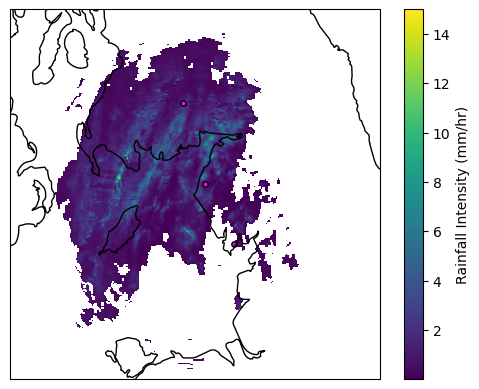

In [14]:
ax = plt.subplot(111, projection=cart_osgb)
plt.imshow(np.ma.masked_less(Nxpol_dataset['Rainfall_ZC_DLUE'][0],0.01),
           origin='lower',
           extent=(Nxpol_dataset['x'][0],Nxpol_dataset['x'][-1],
                   Nxpol_dataset['y'][0],Nxpol_dataset['y'][-1]),
           vmin=0.01,vmax=15)
plt.colorbar(label='Rainfall Intensity (mm/hr)')
ax.coastlines(resolution='10m')
plt.scatter(points_x,points_y,marker='o',c='fuchsia',edgecolors='k',s=15)

To extract time series for these points we can convert their x and y coordiantes into xarray DataArrays with a dimension that account for the number of points we want to extract. When we then cross reference those arrays with our radar dataset we can extract a new 2D array which has the dimensions of "Time" and "POI". This can be especially useful in the future if we want to compare a large number of station locations with data extracted from the radar files.

In [15]:
# Create the DataArrays for x and y of the points:
xpointsDA = xarray.DataArray(points_x, dims=['POI'])
ypointsDA = xarray.DataArray(points_y, dims=['POI'])


# This will select the nearest data from the radar using x and y coordinates of the points
point_dataset = Nxpol_dataset.sel(x=xpointsDA, y=ypointsDA, method='nearest')

Looking at the output Dataset we can see that all the atributes and coordinates from the original grid dataset are retained. It's worth remembering that the x and y values are from the grid cell centre which was nearest to the target point (rather than those of the point itself). Once again we can use the built in plotting calls from xarray to get a simple, annotated plot of a data slice (1 point).

In [16]:
point_dataset

<xarray.Dataset> Size: 1kB
Dimensions:             (Time: 25, POI: 3)
Coordinates:
  * Time                (Time) datetime64[ns] 200B 2018-11-01T00:04:10 ... 20...
    lat                 (POI) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    lon                 (POI) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    x                   (POI) float32 12B 3.275e+05 3.035e+05 2.855e+05
    y                   (POI) float32 12B 4.735e+05 5.235e+05 5.915e+05
Dimensions without coordinates: POI
Data variables:
    crs                 (Time) int64 200B -9223372036854775806 ... -922337203...
    Rainfall_ZC_DLUE    (Time, POI) float32 300B 0.0 0.3574 ... 0.618 1.276
    beam_altitude_DLUE  (Time, POI) float32 300B 989.6 411.9 ... 411.9 1.756e+03
    QIND_DLUE           (Time, POI) float32 300B 0.9213 0.9988 ... 0.9988 0.4724
Attributes: (12/22)
    comment:                         Gridded netcdf output created using weig...
    source:                          NCAS Mobile X-band radar
    data_set_version:                0.0
    location_keywords:               Sandwith, Cumrbia, England, UK
    institution:                     National Centre for Atmospheric Science ...
    creator_name:                    David Dufton
    ...                              ...
    data_source:                     NXPOL radar, Selex Gematronik 50DX Mobil...
    platform_name:                   Sandwith
    platform_location:               X
    licence:                         Data usage licence - UK Government. Open...
    creation_date:                   2024-04-09 08:45
    source_file:                     Gridded from /gws/smf/j07/ncas_radar/duf...

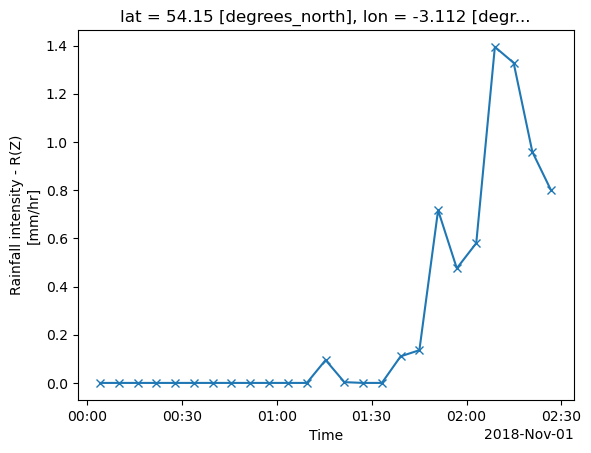

In [17]:
point_dataset['Rainfall_ZC_DLUE'][:,0].plot(marker='x')

And we can loop plotting to view all the timeseries simultaneously:

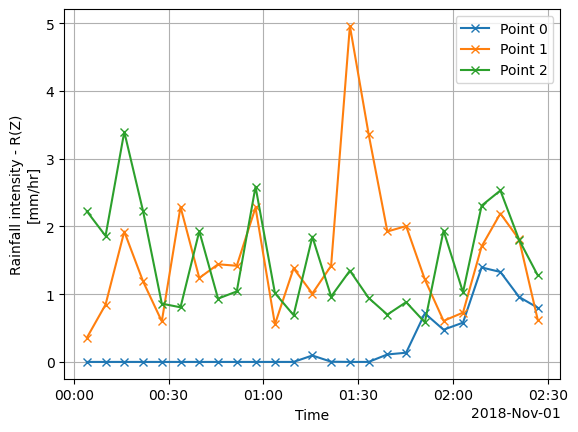

In [18]:
for point_index in range(len(points_of_interest)):
    point_dataset['Rainfall_ZC_DLUE'][:,point_index].plot(marker='x',label='Point {}'.format(point_index))
    
plt.legend()
plt.grid()
plt.title('');

This simple notebook has covered how to open and plot Cartesian gridded radar files (from NXPol). The technqiues are equally applicable to other gridded data which can be read into xarray (including UKMO Cartesian radar composites, especially straightforward if the Iris package is also installed). The files from the RAiN-E campaign are 